<a href="https://colab.research.google.com/github/Saketh1117/Saketh1117/blob/main/cctv_final_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!wget http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz

--2025-12-05 11:02:16--  http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz
Resolving www.svcl.ucsd.edu (www.svcl.ucsd.edu)... 169.228.63.130
Connecting to www.svcl.ucsd.edu (www.svcl.ucsd.edu)|169.228.63.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740306953 (706M) [application/x-gzip]
Saving to: ‘UCSD_Anomaly_Dataset.tar.gz.1’

UCSD_Anomaly_Datase 100%[===================>] 706.01M  1.47MB/s    in 7m 22s  

2025-12-05 11:09:39 (1.60 MB/s) - ‘UCSD_Anomaly_Dataset.tar.gz.1’ saved [740306953/740306953]



In [ ]:
!tar -xf UCSD_Anomaly_Dataset.tar.gz


In [ ]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 19.1 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.knn import KNN
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.io import loadmat
from skimage.feature import hog
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt


In [ ]:
BASE_PATH = "UCSD_Anomaly_Dataset.v1p2/UCSDped2/"
IMG_SIZE = (64, 64)  # smaller resolution for speed
USE_HOG = True       # whether to use HOG features or raw pixels

In [ ]:
def extract_features(frame):
    frame = cv2.resize(frame, IMG_SIZE)
    if USE_HOG:
        features = hog(frame, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)
    else:
        features = frame.flatten() / 255.0
    return features

In [ ]:
def load_ucsd_split(base_path, split="Train"):
    split_path = os.path.join(base_path, split)
    videos = sorted([v for v in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, v))])
    X = []
    for v in tqdm(videos, desc=f"Loading {split} data"):
        vpath = os.path.join(split_path, v)
        frames = sorted([os.path.join(vpath, f) for f in os.listdir(vpath) if f.endswith('.tif')])
        for fpath in frames:
            frame = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            X.append(extract_features(frame))
    return np.array(X)

In [ ]:

def load_ground_truth(base_path):

    test_dir = os.path.join(base_path, "Test")
    sequences = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])

    # Only include folders that are actual videos (not _gt)
    test_sequences = [s for s in sequences if not s.endswith("_gt")]
    y_true = []

    for seq in test_sequences:
        gt_folder = seq + "_gt"
        gt_path = os.path.join(test_dir, gt_folder)
        if not os.path.exists(gt_path):
            continue

        gt_files = sorted([f for f in os.listdir(gt_path) if f.endswith(".bmp")])
        for f in gt_files:
            gt_img = cv2.imread(os.path.join(gt_path, f), cv2.IMREAD_GRAYSCALE)
            # Convert pixel mask to frame-level label: 1 if anomaly present, else 0
            label = 1 if np.any(gt_img > 0) else 0
            y_true.append(label)

    return np.array(y_true)


In [ ]:
USE_HOG = False
X_train_nohog = load_ucsd_split(BASE_PATH, "Train")
X_test_nohog = load_ucsd_split(BASE_PATH, "Test")
y_test_nohog = load_ground_truth(BASE_PATH)

Loading Test data: 100%|██████████| 24/24 [00:01<00:00, 17.93it/s]


***Baseline Models***

In [ ]:
X_train = load_ucsd_split(BASE_PATH, "Train")
X_test = load_ucsd_split(BASE_PATH, "Test")
y_test = load_ground_truth(BASE_PATH)

print(f"Train samples: {X_train.shape}, Test samples: {X_test.shape}, Labels: {y_test.shape}")


Loading Test data: 100%|██████████| 24/24 [00:01<00:00, 22.66it/s]


Train samples: (2550, 4096), Test samples: (2010, 4096), Labels: (2010,)


In [ ]:
print("\nTraining One-Class SVM...")
svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
svm.fit(X_train)


Training One-Class SVM...


OneClassSVM(nu=0.05)

In [ ]:
y_pred = svm.predict(X_test)
y_score = -svm.decision_function(X_test)  # higher score = more anomalous

    # Convert -1/1 to binary
y_pred_bin = (y_pred == -1).astype(int)

auc = roc_auc_score(y_test, y_score)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_bin, average='binary', zero_division=0)

print("svm one class Results:")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

svm one class Results:
AUC: 0.6642
Precision: 0.8679
Recall: 0.3149
F1-score: 0.4622


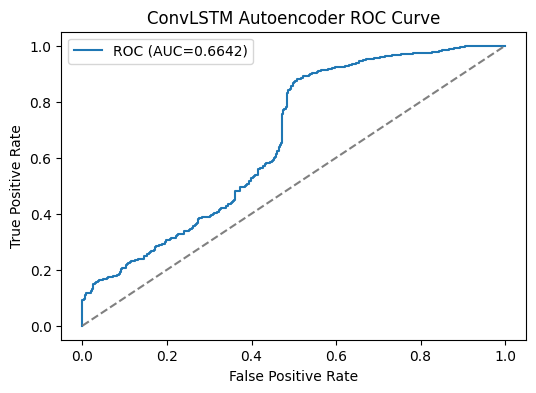

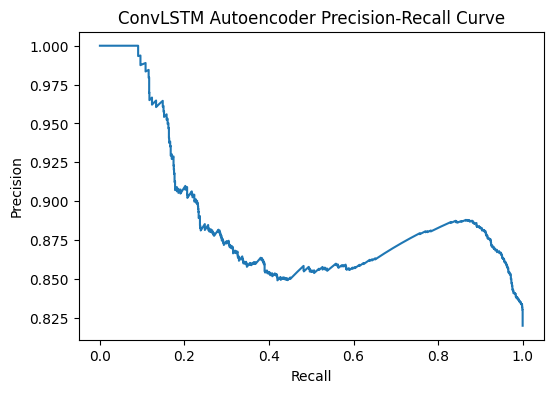

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.4f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ConvLSTM Autoencoder ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_score)
plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"ConvLSTM Autoencoder Precision-Recall Curve")
plt.show()


In [ ]:
print("Training Isolation Forest...")
iso = IsolationForest(contamination=0.05, n_estimators=100, random_state=42)
iso.fit(X_train)

Training Isolation Forest...


IsolationForest(contamination=0.05, random_state=42)

In [ ]:
y_pred = iso.predict(X_test)
y_score = -iso.decision_function(X_test)  # higher score = more anomalous

    # Convert -1/1 to binary
y_pred_bin = (y_pred == -1).astype(int)

auc = roc_auc_score(y_test, y_score)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_bin, average='binary', zero_division=0)

print("isolation forest results:")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

isolation forest results:
AUC: 0.5928
Precision: 0.8365
Recall: 0.3507
F1-score: 0.4942


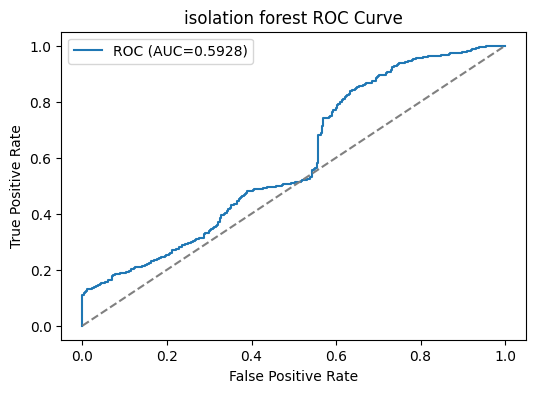

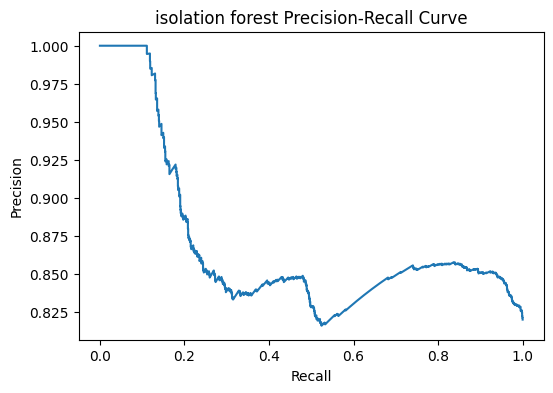

In [18]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.4f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"isolation forest ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_score)
plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"isolation forest Precision-Recall Curve")
plt.show()


In [19]:
print("Training Local Outlier Factor...")
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)
lof.fit(X_train)

Training Local Outlier Factor...


LocalOutlierFactor(contamination=0.05, novelty=True)

In [20]:
y_pred = lof.predict(X_test)
y_score = -lof.decision_function(X_test)  # higher score = more anomalous

    # Convert -1/1 to binary
y_pred_bin = (y_pred == -1).astype(int)

auc = roc_auc_score(y_test, y_score)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_bin, average='binary', zero_division=0)

print("LOC results:")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

LOC results:
AUC: 0.6882
Precision: 0.8364
Recall: 0.9897
F1-score: 0.9066


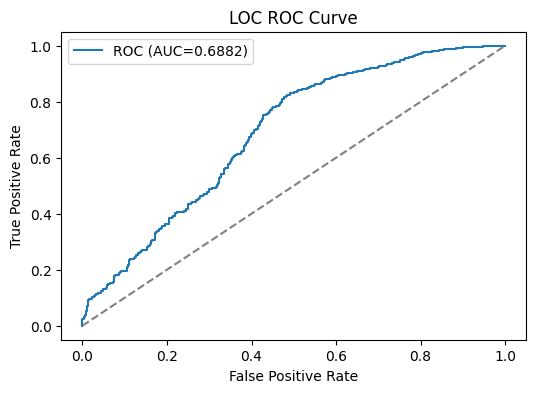

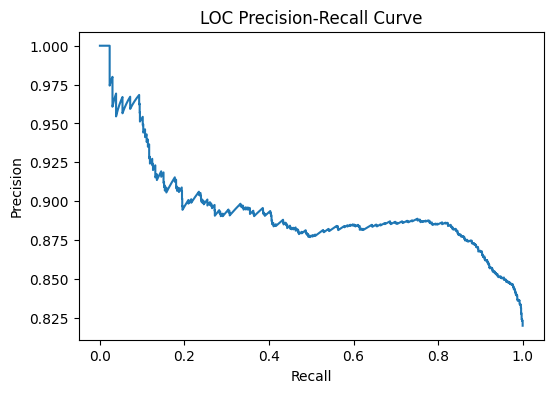

In [21]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.4f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"LOC ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_score)
plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"LOC Precision-Recall Curve")
plt.show()


In [22]:
print("Training KNN Anomaly Detector...")
knn = KNN(contamination=0.05, n_neighbors=10)
knn.fit(X_train)

Training KNN Anomaly Detector...


KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=10, p=2,
  radius=1.0)

In [23]:
y_pred = knn.predict(X_test)
y_score = -knn.decision_function(X_test)  # higher score = more anomalous

    # Convert -1/1 to binary
y_pred_bin = (y_pred == -1).astype(int)

auc = roc_auc_score(y_test, y_score)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_bin, average='binary', zero_division=0)

print("knn results:")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

knn results:
AUC: 0.3801
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


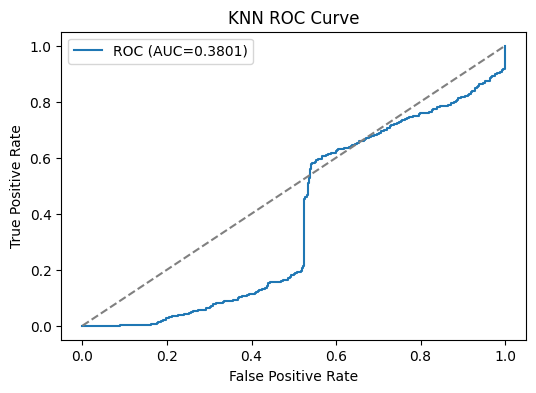

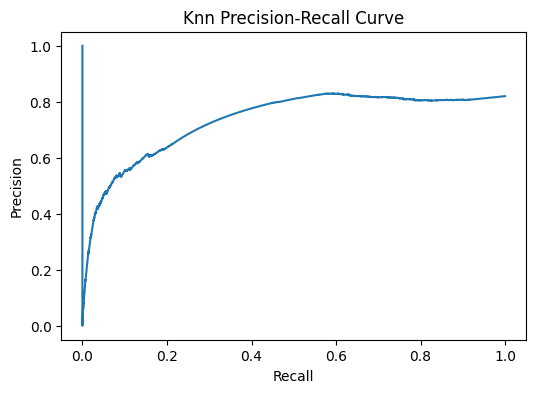

In [24]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.4f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"KNN ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_score)
plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Knn Precision-Recall Curve")
plt.show()


***Auto-Encoder Models***

In [25]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [26]:
def get_autoencoder(model_type, input_dim=None):
    if model_type == "conv":
        return nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    elif model_type == "stacked":
        return nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )
    elif model_type == "spatiotemporal":
        return nn.Sequential(
            nn.Conv3d(1, 32, (3,3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((1,2,2)),
            nn.Conv3d(32, 64, (3,3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2)),
            nn.ConvTranspose3d(64, 32, (3,3,3), stride=(2,2,2), padding=1, output_padding=(1,1,1)),
            nn.ReLU(),
            nn.ConvTranspose3d(32, 1, (3,3,3), stride=(1,2,2), padding=1, output_padding=(0,1,1)),
            nn.Sigmoid()
        )
    else:
        raise ValueError("Unknown model type. Choose from ['conv', 'stacked', 'spatiotemporal'].")


In [27]:
def train_autoencoder(model, X_train, model_type, epochs=20, batch_size=32, lr=1e-3):
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Prepare data
    if model_type == "conv":
        X_train_tensor = torch.FloatTensor(X_train).view(-1, 1, IMG_SIZE[0], IMG_SIZE[1])
    elif model_type == "stacked":
        X_train_tensor = torch.FloatTensor(X_train)
    elif model_type == "spatiotemporal":
        # Expecting shape: (N, 1, T, H, W)
        X_train_tensor = torch.FloatTensor(X_train)
    else:
        raise ValueError("Invalid model type")

    loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch in loader:
            inputs = batch[0].to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(loader):.6f}")

    return model

In [28]:
def evaluate_autoencoder(model, X_test, model_type):
    model.eval()
    errors = []

    if model_type == "conv":
        X_test_tensor = torch.FloatTensor(X_test).view(-1, 1, IMG_SIZE[0], IMG_SIZE[1])
    elif model_type == "stacked":
        X_test_tensor = torch.FloatTensor(X_test)
    elif model_type == "spatiotemporal":
        X_test_tensor = torch.FloatTensor(X_test)
    else:
        raise ValueError("Invalid model type")

    loader = DataLoader(TensorDataset(X_test_tensor), batch_size=32, shuffle=False)
    criterion = nn.MSELoss(reduction="none")

    with torch.no_grad():
        for batch in loader:
            inputs = batch[0].to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            # Mean error per sample
            loss = loss.view(loss.size(0), -1).mean(dim=1)
            errors.extend(loss.cpu().numpy())

    return np.array(errors)

In [29]:
def create_spatiotemporal_clips(X_frames, clip_len=10, img_size=(64, 64)):
    clips = []

    # If frames are flattened, reshape to (N, 1, H, W)
    if X_frames.ndim == 2:
        num_frames = X_frames.shape[0]
        X_frames = X_frames.reshape(num_frames, 1, img_size[0], img_size[1])

    elif X_frames.ndim == 3:
        # (N, H, W) → (N, 1, H, W)
        X_frames = np.expand_dims(X_frames, 1)

    for i in range(len(X_frames) - clip_len):
        clip = X_frames[i:i + clip_len]          # (T, 1, H, W)
        clip = np.transpose(clip, (1, 0, 2, 3))  # (1, T, H, W)
        clips.append(clip)

    return np.array(clips)


In [30]:

def run_autoencoder_pipeline(X_train, X_test, y_test, model_type="conv"):
    print(f"Training {model_type.upper()} Autoencoder...")
    input_dim = X_train.shape[1] if model_type == "stacked" else None
    model = get_autoencoder(model_type, input_dim)


    # Handle temporal reshaping for 3D AE
    if model_type == "spatiotemporal":
        print("Preparing spatio-temporal clips...")
        X_train = create_spatiotemporal_clips(X_train, clip_len=10)
        X_test = create_spatiotemporal_clips(X_test, clip_len=10)
        y_test = y_test[:len(X_test)]  # align with reduced test size


    model = train_autoencoder(model, X_train, model_type=model_type, epochs=10)
    errors = evaluate_autoencoder(model, X_test, model_type)

    threshold_percentile = 95
    threshold = np.percentile(errors, threshold_percentile)
    y_pred = (errors > threshold).astype(int)
    auc_score = roc_auc_score(y_test, errors)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    cm = confusion_matrix(y_test, y_pred)

    print(f"[{model_type.upper()}] AUC: {auc_score:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    print(f"Confusion Matrix:\n{cm}")

# ROC Curve
    fpr, tpr, _ = roc_curve(y_test, errors)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'ROC (AUC={auc_score:.3f})')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_type.upper()}  ROC Curve")
    plt.legend()
    plt.show()

# Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, errors)
    plt.figure(figsize=(6,4))
    plt.plot(recall_vals, precision_vals)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_type.upper()}  Precision-Recall Curve")
    plt.show()

Training CONV Autoencoder...
Epoch [1/10] Loss: 0.017500
Epoch [2/10] Loss: 0.004028
Epoch [3/10] Loss: 0.002840
Epoch [4/10] Loss: 0.002341
Epoch [5/10] Loss: 0.002092
Epoch [6/10] Loss: 0.001931
Epoch [7/10] Loss: 0.001790
Epoch [8/10] Loss: 0.001667
Epoch [9/10] Loss: 0.001558
Epoch [10/10] Loss: 0.001471
[CONV] AUC: 0.583, Precision: 0.871, Recall: 0.053, F1: 0.101
Confusion Matrix:
[[ 349   13]
 [1560   88]]


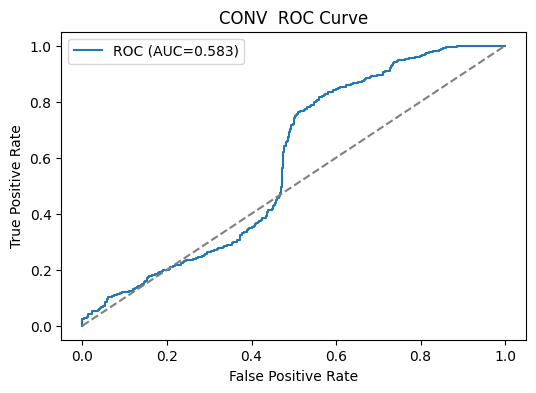

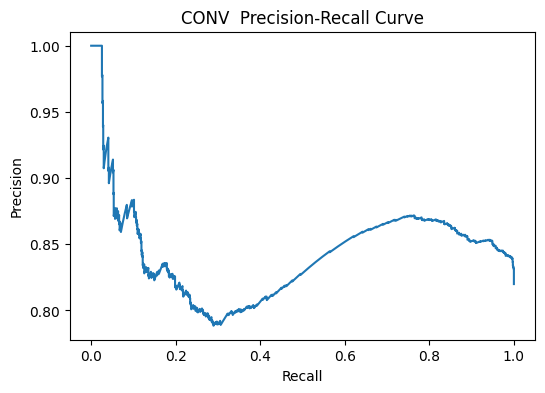

In [31]:
run_autoencoder_pipeline(X_train_nohog, X_test_nohog, y_test_nohog, model_type="conv")

Training STACKED Autoencoder...
Epoch [1/10] Loss: 0.004224
Epoch [2/10] Loss: 0.002173
Epoch [3/10] Loss: 0.002176
Epoch [4/10] Loss: 0.002176
Epoch [5/10] Loss: 0.002172
Epoch [6/10] Loss: 0.002174
Epoch [7/10] Loss: 0.002169
Epoch [8/10] Loss: 0.002175
Epoch [9/10] Loss: 0.002170
Epoch [10/10] Loss: 0.002165
[STACKED] AUC: 0.637, Precision: 1.000, Recall: 0.061, F1: 0.115
Confusion Matrix:
[[ 362    0]
 [1547  101]]


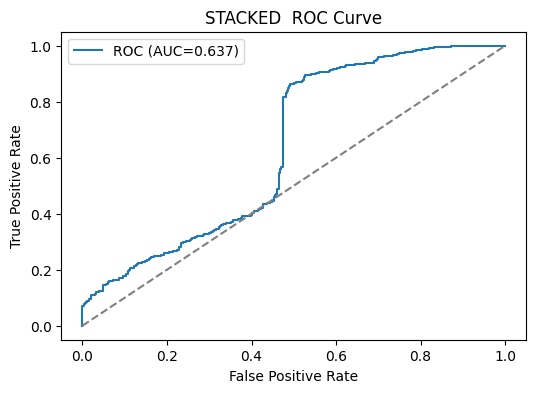

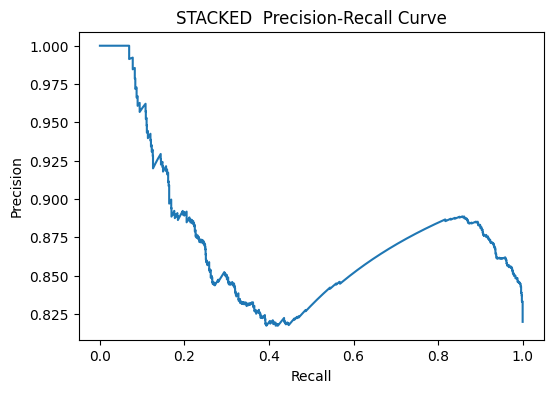

In [33]:
run_autoencoder_pipeline(X_train_nohog, X_test_nohog, y_test_nohog, model_type="stacked")

Training SPATIOTEMPORAL Autoencoder...
Preparing spatio-temporal clips...
Epoch [1/10] Loss: 0.008067
Epoch [2/10] Loss: 0.002368
Epoch [3/10] Loss: 0.001952
Epoch [4/10] Loss: 0.001664
Epoch [5/10] Loss: 0.001477
Epoch [6/10] Loss: 0.001348
Epoch [7/10] Loss: 0.001249
Epoch [8/10] Loss: 0.001177
Epoch [9/10] Loss: 0.001123
Epoch [10/10] Loss: 0.001070
[SPATIOTEMPORAL] AUC: 0.613, Precision: 1.000, Recall: 0.061, F1: 0.115
Confusion Matrix:
[[ 362    0]
 [1538  100]]


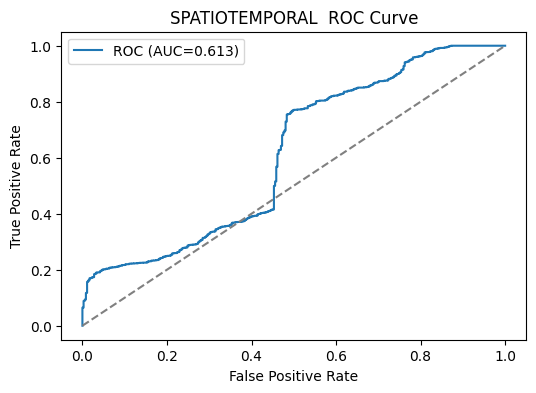

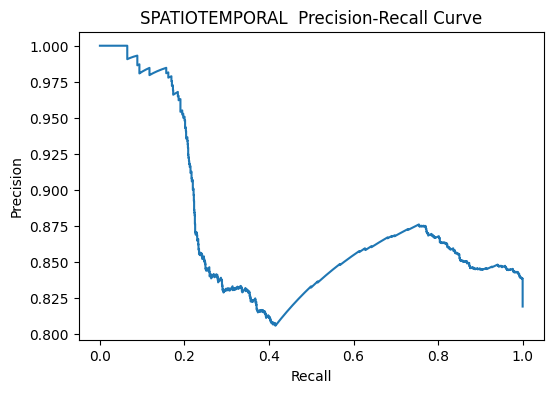

In [34]:
run_autoencoder_pipeline(X_train_nohog, X_test_nohog, y_test_nohog, model_type="spatiotemporal")

***Prediction Based Models***

In [35]:
def create_sequences(X_img, y_test, seq_len=5):
    sequences = []
    y_aligned = []

    start = 0
    # Detect videos dynamically
    test_dir = os.path.join(BASE_PATH, "Test")
    video_dirs = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d)) and not d.endswith("_gt")])

    for vid in video_dirs:
        vid_path = os.path.join(test_dir, vid)
        frame_files = sorted([f for f in os.listdir(vid_path) if f.endswith(".tif") or f.endswith(".bmp")])
        num_frames = len(frame_files)
        frames = X_img[start:start+num_frames]
        labels = y_test[start:start+num_frames]

        for i in range(num_frames - seq_len):
            sequences.append(frames[i:i+seq_len])
            y_aligned.append(labels[i+seq_len])  # last frame label
        start += num_frames

    return np.array(sequences, dtype=np.float32), np.array(y_aligned, dtype=np.int32)

In [36]:
X_test_seq, y_test_aligned = create_sequences(X_test_nohog.reshape(-1,64,64), y_test_nohog, seq_len=5)

In [37]:
def convlstm_autoencoder(X_train_img, X_test_seq, seq_len=5, epochs=5, batch_size=16, lr=1e-3):
    # Create training sequences
    train_seq = [X_train_img[i:i+seq_len] for i in range(len(X_train_img)-seq_len)]
    X_train_tensor = torch.FloatTensor(np.array(train_seq)).unsqueeze(1).to(DEVICE)  # (N, 1, seq_len, H, W)
    X_test_tensor = torch.FloatTensor(X_test_seq).unsqueeze(1).to(DEVICE)

    # Simple 3D Conv Autoencoder
    model = nn.Sequential(
        nn.Conv3d(1,16,(3,3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.Conv3d(16,8,(3,3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.Conv3d(8,16,(3,3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.Conv3d(16,1,(3,3,3),stride=1,padding=1),
        nn.Sigmoid()
    ).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

    # Training
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"[ConvLSTM] Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(loader):.6f}")

    # Evaluate
    model.eval()
    errors = []
    with torch.no_grad():
        for seq in X_test_tensor:
            seq = seq.unsqueeze(0)
            pred = model(seq).cpu().numpy().squeeze()  # (seq_len, H, W)
            true_frame = seq[0,0,-1].cpu().numpy()
            pred_frame = pred[-1]
            error = np.mean((pred_frame - true_frame)**2)
            errors.append(error)
    return np.array(errors)

In [38]:
conv_errors = convlstm_autoencoder(X_train_nohog.reshape(-1,64,64), X_test_seq)

[ConvLSTM] Epoch 1/5, Loss: 0.005406
[ConvLSTM] Epoch 2/5, Loss: 0.000939
[ConvLSTM] Epoch 3/5, Loss: 0.000645
[ConvLSTM] Epoch 4/5, Loss: 0.000479
[ConvLSTM] Epoch 5/5, Loss: 0.000404


In [39]:
threshold_percentile = 95
threshold = np.percentile(conv_errors, threshold_percentile)
y_pred = (conv_errors > threshold).astype(int)
auc_score = roc_auc_score(y_test_aligned, conv_errors)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_aligned, y_pred, average='binary')
cm = confusion_matrix(y_test_aligned, y_pred)

print(f"[ConvLSTM Autoencoder] AUC: {auc_score:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
print(f"Confusion Matrix:\n{cm}")



[ConvLSTM Autoencoder] AUC: 0.659, Precision: 0.959, Recall: 0.058, F1: 0.110
Confusion Matrix:
[[ 333    4]
 [1519   94]]


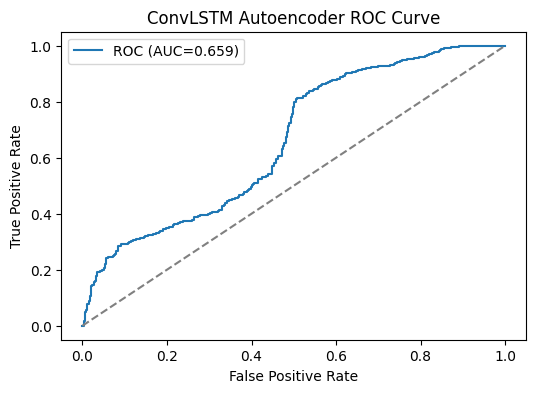

In [40]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_aligned, conv_errors)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc_score:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ConvLSTM Autoencoder ROC Curve")
plt.legend()
plt.show()

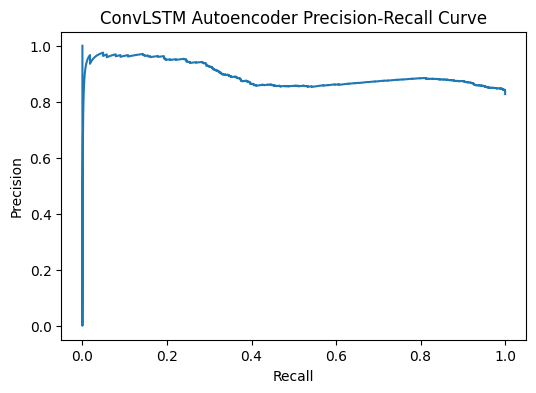

In [41]:
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test_aligned, conv_errors)
plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"ConvLSTM Autoencoder Precision-Recall Curve")
plt.show()

In [42]:
def predictive_cnn(X_train_img, X_test_seq, seq_len=5, epochs=5, batch_size=16, lr=1e-3):
    # Train sequences: X = first seq_len-1 frames, Y = last frame
    X_train_seq, Y_train = [], []
    for i in range(len(X_train_img)-seq_len):
        X_train_seq.append(X_train_img[i:i+seq_len-1])
        Y_train.append(X_train_img[i+seq_len-1])
    X_train_tensor = torch.FloatTensor(np.array(X_train_seq)).unsqueeze(1).to(DEVICE)
    Y_train_tensor = torch.FloatTensor(np.array(Y_train)).unsqueeze(1).unsqueeze(1).to(DEVICE)

    X_test_tensor = torch.FloatTensor(X_test_seq[:,:-1]).unsqueeze(1).to(DEVICE)
    Y_test_true = X_test_seq[:,-1]  # last frame

    # CNN model
    model = nn.Sequential(
        nn.Conv3d(1,16,(3,3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.Conv3d(16,8,(3,3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.Conv3d(8,1,(3,3,3),stride=1,padding=1),
        nn.Sigmoid()
    ).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)

    # Training
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch in loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"[PredCNN] Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(loader):.6f}")

    # Evaluate
    model.eval()
    errors = []
    with torch.no_grad():
        for i in range(X_test_tensor.shape[0]):
            seq = X_test_tensor[i].unsqueeze(0)
            pred = model(seq).cpu().numpy().squeeze()
            true_frame = Y_test_true[i]
            error = np.mean((pred - true_frame)**2)
            errors.append(error)
    return np.array(errors)

In [43]:
cnn_errors = predictive_cnn(X_train_nohog.reshape(-1,64,64), X_test_seq)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([16, 1, 1, 64, 64])) that is different to the input size (torch.Size([16, 1, 4, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([1, 1, 1, 64, 64])) that is different to the input size (torch.Size([1, 1, 4, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PredCNN] Epoch 1/5, Loss: 0.006698
[PredCNN] Epoch 2/5, Loss: 0.001759
[PredCNN] Epoch 3/5, Loss: 0.001248
[PredCNN] Epoch 4/5, Loss: 0.001154
[PredCNN] Epoch 5/5, Loss: 0.001079


In [44]:
threshold_percentile = 95
threshold = np.percentile(cnn_errors, threshold_percentile)
y_pred = (cnn_errors > threshold).astype(int)
auc_score = roc_auc_score(y_test_aligned, cnn_errors)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_aligned, y_pred, average='binary')
cm = confusion_matrix(y_test_aligned, y_pred)

print(f"[Predictive cnn] AUC: {auc_score:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
print(f"Confusion Matrix:\n{cm}")



[Predictive cnn] AUC: 0.659, Precision: 0.949, Recall: 0.058, F1: 0.109
Confusion Matrix:
[[ 332    5]
 [1520   93]]


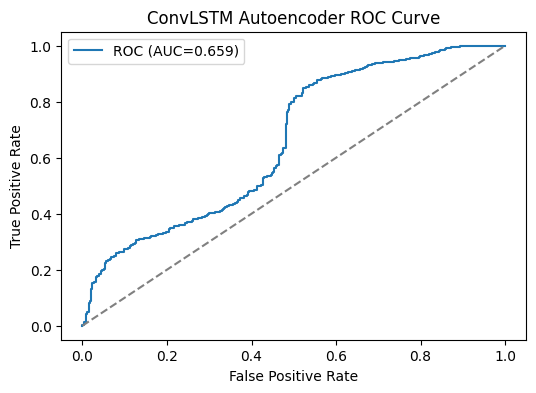

In [45]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_aligned, cnn_errors)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc_score:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ConvLSTM Autoencoder ROC Curve")
plt.legend()
plt.show()

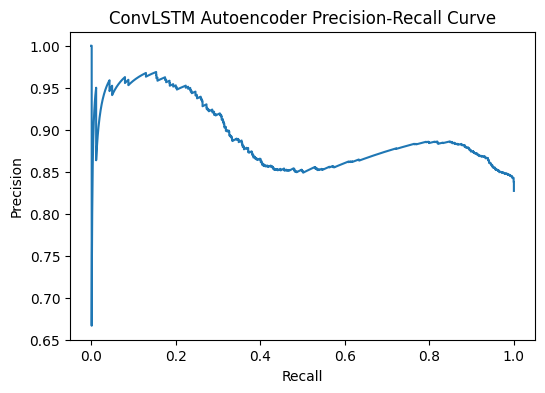

In [46]:
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test_aligned, cnn_errors)
plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"ConvLSTM Autoencoder Precision-Recall Curve")
plt.show()

***Generative Models***

In [47]:
def gan_generator(latent_dim=100):
    return nn.Sequential(
        nn.Linear(latent_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 64*64),
        nn.Sigmoid()
    )

In [48]:
def gan_discriminator():
    return nn.Sequential(
        nn.Linear(64*64, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

In [49]:
def train_gan(X_train_flat, latent_dim=100, epochs=5, batch_size=32, lr=2e-4):
    X_train_tensor = torch.FloatTensor(X_train_flat).to(DEVICE)
    dataset = TensorDataset(X_train_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    G = gan_generator(latent_dim).to(DEVICE)
    D = gan_discriminator().to(DEVICE)

    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=lr)
    optimizer_D = optim.Adam(D.parameters(), lr=lr)

    for epoch in range(epochs):
        for batch in loader:
            real = batch[0]
            batch_size_curr = real.size(0)

            # Labels
            valid = torch.ones(batch_size_curr,1).to(DEVICE)
            fake = torch.zeros(batch_size_curr,1).to(DEVICE)

            optimizer_D.zero_grad()
            z = torch.randn(batch_size_curr, latent_dim).to(DEVICE)
            gen_imgs = G(z)
            loss_real = criterion(D(real), valid)
            loss_fake = criterion(D(gen_imgs.detach()), fake)
            loss_D = (loss_real + loss_fake)/2
            loss_D.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()
            z = torch.randn(batch_size_curr, latent_dim).to(DEVICE)
            gen_imgs = G(z)
            loss_G = criterion(D(gen_imgs), valid)
            loss_G.backward()
            optimizer_G.step()
        print(f"[GAN] Epoch {epoch+1}/{epochs}, D_loss: {loss_D.item():.4f}, G_loss: {loss_G.item():.4f}")
    return G, D

In [50]:
def gan_anomaly_score(generator, X_test_flat, latent_dim=100, steps=500, lr=1e-2):
    X_test_tensor = torch.FloatTensor(X_test_flat).to(DEVICE)
    errors = []
    for x in X_test_tensor:
        z = torch.randn(1, latent_dim, requires_grad=True, device=DEVICE)
        optimizer = optim.Adam([z], lr=lr)
        for _ in range(steps):
            gen = generator(z)
            loss = nn.MSELoss()(gen, x.unsqueeze(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pred = generator(z).detach()
        mse = ((pred - x.unsqueeze(0))**2).mean().item()
        errors.append(mse)
    return np.array(errors)

In [52]:
G, D = train_gan(X_train_nohog, epochs=5)
gan_errors = gan_anomaly_score(G, X_test_nohog)

[GAN] Epoch 1/5, D_loss: 0.4683, G_loss: 2.3105
[GAN] Epoch 2/5, D_loss: 0.0009, G_loss: 6.8404
[GAN] Epoch 3/5, D_loss: 0.1080, G_loss: 4.2393
[GAN] Epoch 4/5, D_loss: 0.0130, G_loss: 6.7431
[GAN] Epoch 5/5, D_loss: 0.0037, G_loss: 6.7972


In [53]:
threshold_percentile = 95
threshold = np.percentile(gan_errors, threshold_percentile)
y_pred = (gan_errors > threshold).astype(int)
auc_score = roc_auc_score(y_test, gan_errors)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
cm = confusion_matrix(y_test, y_pred)

print(f"[GAN] AUC: {auc_score:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
print(f"Confusion Matrix:\n{cm}")

[GAN] AUC: 0.504, Precision: 0.990, Recall: 0.061, F1: 0.114
Confusion Matrix:
[[ 361    1]
 [1548  100]]


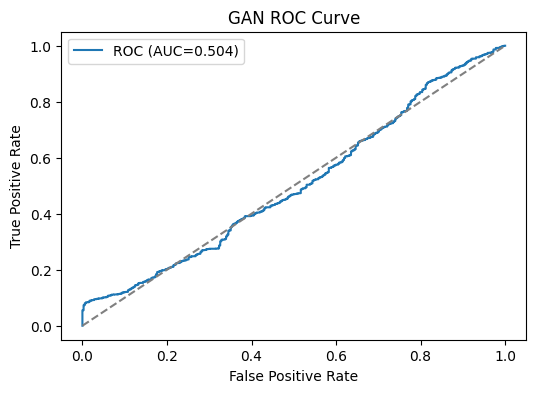

In [54]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, gan_errors)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc_score:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"GAN ROC Curve")
plt.legend()
plt.show()

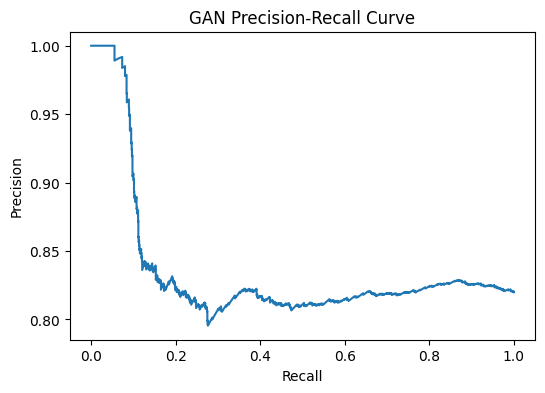

In [55]:
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, gan_errors)
plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"GAN Precision-Recall Curve")
plt.show()

In [56]:
def gan_autoencoder(latent_dim=100):
    generator = gan_generator(latent_dim)
    autoencoder = nn.Sequential(
        nn.Linear(64*64, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 64*64),
        nn.Sigmoid()
    )
    return generator, autoencoder

In [57]:
def train_gan_autoencoder(X_train_flat, latent_dim=100, epochs=5, batch_size=32, lr=2e-4):
    X_train_tensor = torch.FloatTensor(X_train_flat).to(DEVICE)
    dataset = TensorDataset(X_train_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    G, AE = gan_autoencoder(latent_dim)
    G, AE = G.to(DEVICE), AE.to(DEVICE)

    criterion = nn.MSELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=lr)
    optimizer_AE = optim.Adam(AE.parameters(), lr=lr)

    for epoch in range(epochs):
        for batch in loader:
            real = batch[0]

            # GAN step
            optimizer_G.zero_grad()
            z = torch.randn(real.size(0), latent_dim).to(DEVICE)
            gen_imgs = G(z)
            loss_G = criterion(gen_imgs, real)
            loss_G.backward()
            optimizer_G.step()

            # Autoencoder step
            optimizer_AE.zero_grad()
            recon = AE(real)
            loss_AE = criterion(recon, real)
            loss_AE.backward()
            optimizer_AE.step()
        print(f"[GAN+AE] Epoch {epoch+1}/{epochs}, G_loss: {loss_G.item():.4f}, AE_loss: {loss_AE.item():.4f}")
    return G, AE

In [58]:
def gan_autoencoder_anamoly_score(generator, autoencoder, X_test_flat, latent_dim=100, steps=200, lr=1e-2):
    """
    Compute anomaly scores using GAN+AE hybrid
    """
    X_test_tensor = torch.FloatTensor(X_test_flat).to(DEVICE)
    errors = []
    for x in X_test_tensor:
        z = torch.randn(1, latent_dim, requires_grad=True, device=DEVICE)
        optimizer = optim.Adam([z], lr=lr)
        for _ in range(steps):
            gen = generator(z)
            recon = autoencoder(gen)
            loss = nn.MSELoss()(recon, x.unsqueeze(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pred = autoencoder(generator(z)).detach()
        mse = ((pred - x.unsqueeze(0))**2).mean().item()
        errors.append(mse)
    return np.array(errors)

In [59]:
G_h, AE_h = train_gan_autoencoder(X_train_nohog, epochs=5)
gan_ae_errors = gan_autoencoder_anamoly_score(G_h, AE_h, X_test_nohog)

[GAN+AE] Epoch 1/5, G_loss: 0.0027, AE_loss: 0.0020
[GAN+AE] Epoch 2/5, G_loss: 0.0029, AE_loss: 0.0025
[GAN+AE] Epoch 3/5, G_loss: 0.0024, AE_loss: 0.0019
[GAN+AE] Epoch 4/5, G_loss: 0.0026, AE_loss: 0.0022
[GAN+AE] Epoch 5/5, G_loss: 0.0021, AE_loss: 0.0018


In [60]:
threshold_percentile = 95
threshold = np.percentile(gan_ae_errors, threshold_percentile)
y_pred = (gan_ae_errors > threshold).astype(int)
auc_score = roc_auc_score(y_test, gan_ae_errors)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
cm = confusion_matrix(y_test, y_pred)

print(f"[GAN] AUC: {auc_score:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
print(f"Confusion Matrix:\n{cm}")

[GAN] AUC: 0.636, Precision: 0.990, Recall: 0.061, F1: 0.114
Confusion Matrix:
[[ 361    1]
 [1548  100]]


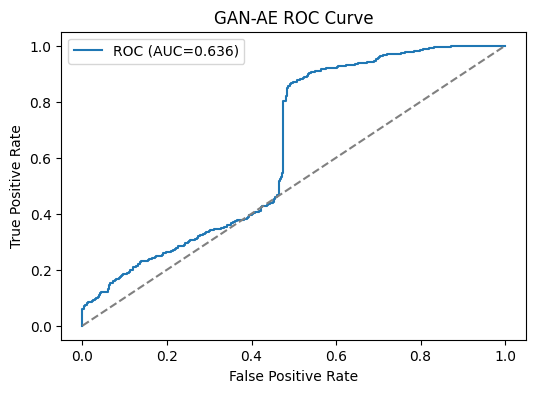

In [61]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, gan_ae_errors)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc_score:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"GAN-AE ROC Curve")
plt.legend()
plt.show()

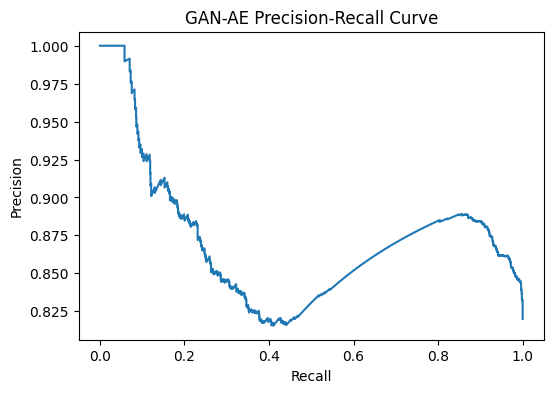

In [62]:
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, gan_ae_errors)
plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"GAN-AE Precision-Recall Curve")
plt.show()